# Gestion de Datos

Para contemplar el universo de probabilidades y compararlo con los resultados optimizados, se ha realizado una simulación de Monte Carlo.

In [193]:
n_samples = 10000

In [194]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

def plot_sharpe(returns, mask=None, frontier=None):
    # Generamos los pesos aleatoriamente
    n_assets = len(returns.iloc[0])
    mask = np.ones(n_assets) if mask is None else mask

    generator = np.random.default_rng(42)
    weights = generator.random(size=(n_samples, n_assets))
    weights = (mask * weights) / np.sum(weights, axis=1, keepdims=True)

    daily_returns = returns @ weights.T
    daily_returns_std = daily_returns.std(axis=0)
    daily_returns_mean = daily_returns.mean(axis=0)

    plt.scatter(x=daily_returns_std, y=daily_returns_mean, c=daily_returns_mean/daily_returns_std, marker="o", cmap="coolwarm")

    if frontier is not None:
        best = frontier.iloc[frontier['sharpe'].idxmax()]
        plt.scatter(frontier['volatility'], frontier['return'], color='blue', marker='.', s=300)
        plt.scatter(best['volatility'], best['return'], color='red', marker='*', s=300)

    plt.grid(True)
    plt.xlabel("Riesgo (std)")
    plt.ylabel("Retorno esperado")
    plt.title("Retorno vs. Riesgo")
    plt.show()

In [195]:
# Esta funcion ha sido desarrollada por Gemini 3 en su totalidad, se ha limpiado para adaptarla
def round_weights(weights, decimals=3):

    rounded_weights = np.floor(np.array(weights) * (10**decimals)) / (10**decimals)
    rounded_weights[rounded_weights < 0] = 0
    diff = round(1.0 - np.sum(rounded_weights), decimals)
    priority_idxs = np.argsort(weights)[::-1]
    step = 1 / (10**decimals)

    i = 0
    while diff > 0:
        i += 1
        diff = round(diff - step, decimals)
        idx = priority_idxs[i % len(priority_idxs)]
        rounded_weights[idx] = round(rounded_weights[idx] + step, decimals)

    return rounded_weights

In [196]:
def get_data(csv=True):
    if csv:
        return pd.read_csv('resources/returns.csv', header=0)
    else:

        tickers = [
          # --- Extrema Volatilidad & Cripto-Proxies ---
          'MSTR', 'MARA', 'RIOT', 'CLSK', 'COIN', 'CAN', 'WULF',

          # --- ETFs Apalancados (Varianza Extrema) ---
          'TQQQ', 'SOXL', 'UPRO', 'LABU', 'FNGU', 'YINN', 'BOIL', 'UVIX', 'TMF',

          # --- Tech Agresiva & Memes ---
          'TSLA', 'GME', 'AMC', 'PLTR', 'SNOW', 'U', 'PATH', 'AI', 'UPST',
          'CVNA', 'DKNG', 'HOOD', 'PYPL', 'RIVN', 'LCID', 'NIO',

          # --- Biotecnología (Gaps de precio) ---
          'MRNA', 'BNTX', 'SAVA', 'VKTX', 'CRSP', 'ILMN',

          # --- Commodities & Energía Volátil ---
          'XOP', 'UNG', 'XME', 'GDXJ', 'FCX', 'SQM', 'ALB',

          # --- China & Emergentes (Riesgo Político) ---
          'BABA', 'JD', 'PDD', 'KWEB',

          # --- Refugios (Para probar la lógica de asignación) ---
          'SHV', 'BIL'
        ]

        # Descarga de datos (2 años para tener historial suficiente)
        return yf.download(tickers, period="2y", interval="1d")['Close'].pct_change().dropna()

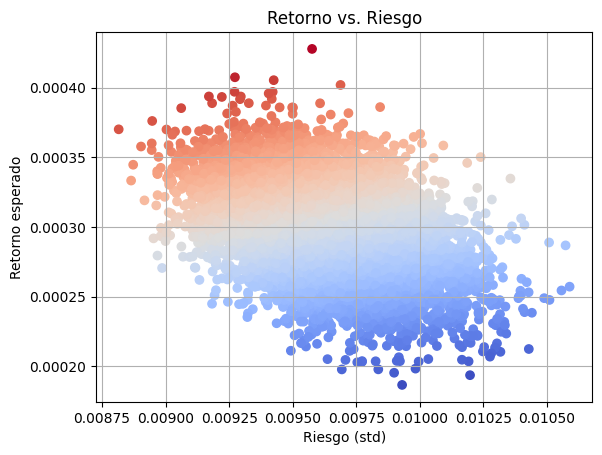

In [197]:

returns = get_data(csv=True)
if not len(returns):
    exit(-1)

plot_sharpe(returns)


Ahora que sabemos que aspecto tiene, vamos a filtrar los activos que tengan una correlación alta, para diversificar la cartera correctamente y reducir la volatilidad (si dos activos con una correlación alta sufren una caída del precio, esto condiciona nuestro ratio de sharpe).
Tambien calculamos la curtosis y eliminamos aquellos que tienen una curtosis muy alta

Mirar asimetrias tambien, queremos una cartera poco volatil y que nos permita maximizar el rendimiento sin sustos

{'30', '11', '44', '10', '37', '29', '54', '20', '27', '3', '58', '48', '40', '9', '14', '13', '55', '2', '8', '1', '46', '32', '31', '28', '26', '24', '38', '6', '51', '35', '18'}
[29, 10, 43, 9, 36, 28, 53, 19, 26, 2, 57, 47, 39, 8, 13, 12, 54, 1, 7, 0, 45, 31, 30, 27, 25, 23, 37, 5, 50, 34, 17]
31


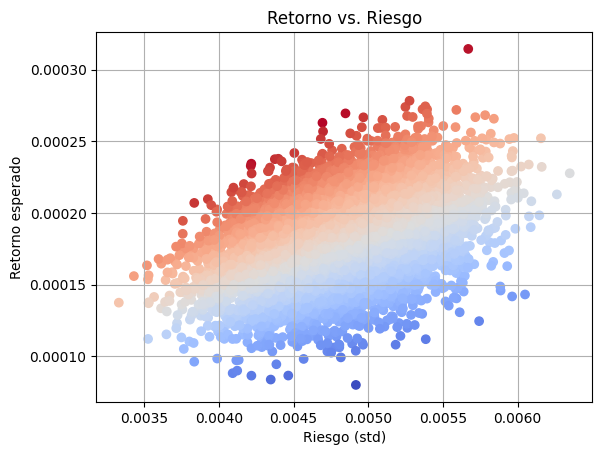

In [198]:
sharpe = returns.mean() / returns.std()

drop = set()

# Curtosis
kurtosis = returns.kurtosis()
for asset, _ in returns.items():
    if (kurtosis[asset] > 5):
        drop.add(asset)

# Obtenemos la correlacion absoluta
correlations = returns.corr().abs()
correlated = correlations[(correlations >= 0.9) & (correlations < 1)].stack()

for (a, b), correlation in correlated.items():
    if pd.isna(correlation):
        continue

    if a in drop or b in drop:
        continue
    if sharpe[a] > sharpe[b]:
        drop.add(b)
    else:
        drop.add(a)


drop_indexes = [returns.columns.get_loc(col) for col in drop]

print(drop)
print(drop_indexes)
print(len(drop_indexes))

mask = np.ones(len(returns.iloc[0]))
mask[drop_indexes] = 0

plot_sharpe(returns, mask)

Lo que usabamos antes:


´´
daily_returns = returns @ weights.T
daily_returns_std = daily_returns.std(axis=0)
daily_returns_mean = daily_returns.mean(axis=0)
Objective -> daily_returns_mean/daily_returns_std

No vale porque no es convexo



<Axes: title={'center': 'Evolución de Retornos por Sector'}>

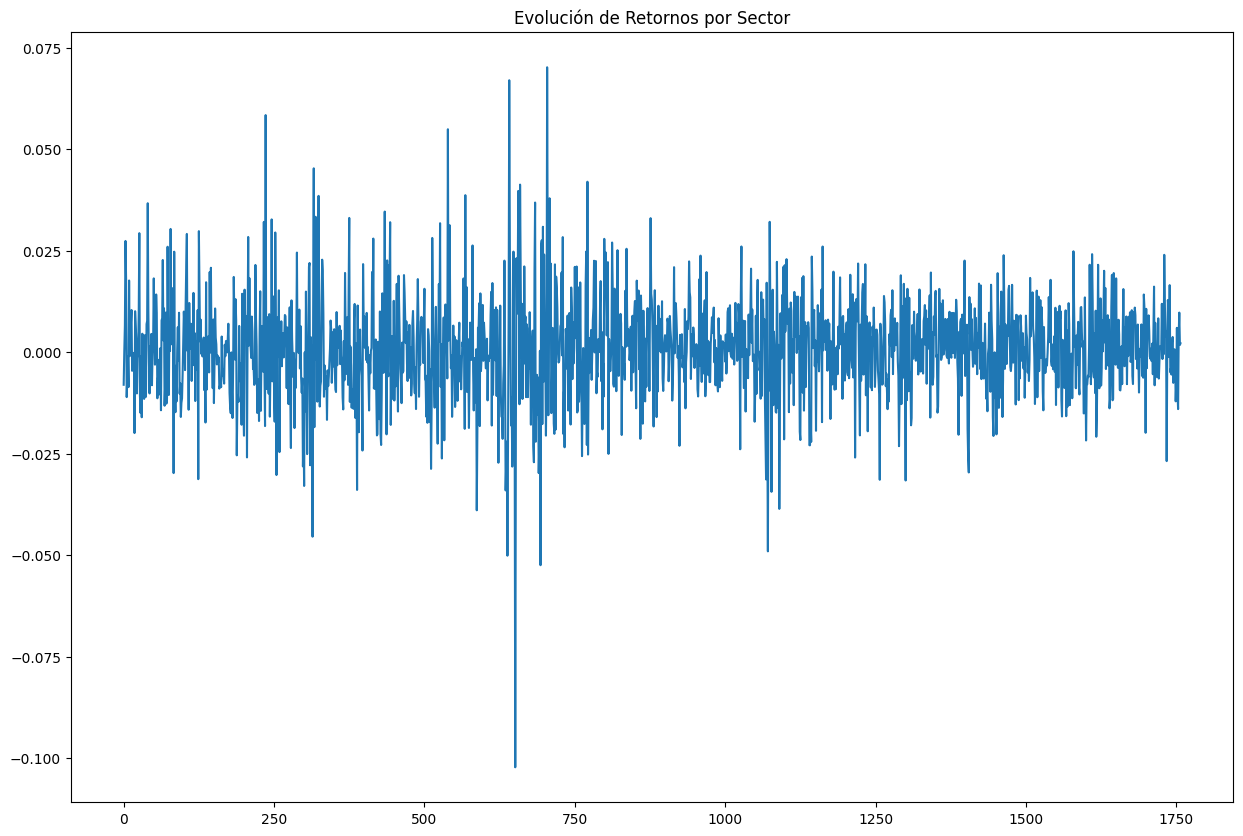

In [199]:
sectores = pd.read_csv('resources/sectores.csv')
sectores['Ticker'] = sectores['Ticker'].astype(str)
results = returns.T
returns_final = pd.merge(
    results,
    sectores[['Ticker', 'SECTOR']],
    left_index=True,     # Usa el índice del primer DF (los nombres de activos)
    right_on='Ticker',   # Usa la columna 'Ticker' del segundo DF
    how='left'
)

returns_final.index = returns_final['Ticker']
returns_final = returns_final.drop(columns=['Ticker'])
sectores = returns_final.groupby('SECTOR').mean()
sectores.loc['Residential & Commercial REITs'].T.plot(figsize=(15, 10), title="Evolución de Retornos por Sector")



In [240]:
sectores_filtrados = returns_final[returns_final['SECTOR'].isin(['Telecommunications Services', 'Healthcare Equipment & Supplies', 'Personal & Household Products & Services', 'Consumer Goods Conglomerates'])]
sectores_filtrados

,0,1,2,3,4,5,6,7,8,9,...,1749,1750,1751,1752,1753,1754,1755,1756,1757,SECTOR
Ticker,,,,,,,,,,,,,,,,,,,,,
1,-0.028988,-0.001839,0.034392,0.010620,-0.007067,-0.014285,-0.015079,-0.009216,0.021979,-0.021979,...,-0.007039,0.002697,-0.006444,0.001043,-0.005641,0.010421,0.015840,-0.001430,-0.004506,Healthcare Equipment & Supplies
8,-0.022658,0.042820,0.020742,0.055147,-0.038666,0.000000,-0.011605,0.023078,-0.030890,-0.012827,...,-0.006466,0.004961,-0.002585,0.004305,-0.007329,0.002809,0.008807,-0.002784,-0.005160,Healthcare Equipment & Supplies
14,-0.026451,-0.034613,-0.002136,0.058168,0.026881,0.004900,0.006819,0.006773,-0.023416,-0.004947,...,-0.002145,-0.001536,0.001229,-0.007392,-0.001548,0.006328,0.000615,0.010249,-0.007178,Personal & Household Products & Services
15,-0.077817,-0.026356,0.037850,-0.031933,0.120729,-0.095964,0.039497,0.055158,0.022007,-0.006423,...,0.003950,-0.006748,-0.004446,0.002109,-0.007046,0.010783,-0.001400,-0.003041,-0.008702,Telecommunications Services
35,0.007273,0.060932,0.036855,0.106018,-0.007423,0.004461,-0.001486,0.033605,0.008584,0.011331,...,-0.003136,0.004608,-0.001288,-0.011295,-0.008979,0.004125,-0.002248,-0.002253,0.005810,Healthcare Equipment & Supplies
36,-0.040546,0.028554,0.077358,0.019657,-0.004879,-0.017263,0.002484,0.000000,-0.014370,-0.022273,...,0.000511,-0.003068,0.009176,-0.000254,-0.005854,-0.004092,0.005623,-0.003958,-0.002947,Consumer Goods Conglomerates
46,-0.019430,-0.019208,0.045031,0.076918,-0.004840,0.015512,-0.006389,-0.017242,0.017242,-0.000535,...,0.000779,0.003579,0.001241,-0.006536,-0.003911,0.006094,0.003577,0.000931,-0.003262,Personal & Household Products & Services
52,-0.060292,0.015417,-0.019566,0.008534,0.014065,-0.014065,-0.053831,-0.024207,0.028681,-0.021053,...,-0.005343,-0.013625,-0.001143,0.006275,-0.005417,0.000858,0.011642,0.002256,0.007018,Telecommunications Services
57,-0.032860,0.032860,-0.005092,-0.007412,-0.005327,-0.009392,-0.034283,-0.007843,0.013408,0.042375,...,0.001643,0.003279,-0.005745,0.006290,-0.003551,0.005457,0.010557,0.004835,-0.002146,Telecommunications Services


In [260]:
datos = sectores_filtrados.iloc[:, :-1]
media = datos.mean(axis=1)
riesgo = datos.std(axis=1)
sharpe = media/riesgo

pd.DataFrame({ 'Media': media, 'Riesgo': riesgo, 'Sharpe': sharpe }).sort_values(by=['Media', 'Riesgo', 'Sharpe'], ascending=[False, True, False])

,Media,Riesgo,Sharpe
Ticker,,,
36,0.000370,0.015514,0.023854
1,0.000354,0.017948,0.019743
8,0.000323,0.020245,0.015945
35,0.000277,0.017657,0.015702
46,0.000186,0.017046,0.010901
14,0.000092,0.016540,0.005563
52,0.000059,0.019782,0.003005
15,-0.000056,0.024194,-0.002335
57,-0.000095,0.018712,-0.005092


In [200]:
sectores.std(axis=1).sort_values(ascending=True)

SECTOR
Residential & Commercial REITs                      0.012358
Beverages                                           0.012588
Freight & Logistics Services                        0.013255
Healthcare Equipment & Supplies                     0.013694
Electric Utilities & IPPs                           0.013824
Personal & Household Products & Services            0.014641
Pharmaceuticals                                     0.014647
Banking Services                                    0.015494
Consumer Goods Conglomerates                        0.015514
Oil & Gas                                           0.015675
Telecommunications Services                         0.016075
Machinery, Tools, Heavy Vehicles, Trains & Ships    0.016226
Aerospace & Defense                                 0.016418
Hotels & Entertainment Services                     0.016877
Software & IT Services                              0.017458
Insurance                                           0.018076
Food & Drug Retai

In [224]:
sectores.mean(axis=1).sort_values(ascending=False)

,0,1,2,3,4,5,6,7,8,9,...,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757
SECTOR,,,,,,,,,,,,,,,,,,,,,
Aerospace & Defense,-0.021189,0.029352,0.011746,0.033302,-0.007309,-0.008561,0.003829,-0.002323,0.009792,0.001202,...,0.019896,0.002168,0.003525,0.001450,-0.002210,-0.009258,0.002028,0.001567,-0.003444,-0.004515
Automobiles & Auto Parts,-0.033985,0.003697,0.001229,0.071120,-0.018476,-0.027172,0.028337,-0.011710,-0.025046,0.047178,...,-0.004228,-0.007087,0.021113,0.020676,-0.002732,0.014936,0.009390,0.011944,-0.010610,0.001332
Banking Services,-0.042830,-0.006936,0.053471,0.011879,-0.022714,-0.025110,0.023780,0.038852,0.031419,-0.038071,...,0.002596,0.002972,0.002061,0.002387,0.001383,-0.003528,0.004787,0.004999,-0.002097,-0.007749
Beverages,-0.012322,-0.007915,0.022348,0.045327,-0.026273,0.015023,-0.000367,-0.012871,0.007577,0.032108,...,0.002237,0.001282,0.000331,-0.000047,-0.000213,-0.005178,-0.000311,0.001837,0.001312,-0.008560
Consumer Goods Conglomerates,-0.040546,0.028554,0.077358,0.019657,-0.004879,-0.017263,0.002484,0.000000,-0.014370,-0.022273,...,-0.005857,0.000511,-0.003068,0.009176,-0.000254,-0.005854,-0.004092,0.005623,-0.003958,-0.002947
Electric Utilities & IPPs,0.015693,0.037942,0.006364,0.010326,-0.003783,-0.000294,0.010965,-0.000309,-0.003789,-0.019136,...,-0.003275,-0.003790,0.012387,-0.006675,-0.001576,-0.002397,0.007498,0.004603,-0.004330,-0.001858
Electronic Equipment & Parts,-0.027713,0.031945,0.027767,0.022118,-0.025776,-0.009667,0.019241,0.001813,0.007221,-0.064539,...,0.002745,-0.001247,0.004233,0.004215,-0.008946,-0.001499,0.006479,0.006373,-0.002994,-0.003004
Food & Drug Retailing,-0.038136,-0.020619,0.010854,0.072845,-0.018416,-0.014982,-0.018088,0.000960,-0.009643,0.016338,...,-0.001506,-0.001723,-0.006057,-0.004785,-0.003494,-0.003726,0.012439,0.001084,-0.003255,0.003688
Freight & Logistics Services,-0.022568,0.022807,0.055559,-0.008595,0.004068,-0.012781,0.001179,0.023115,-0.003524,-0.031707,...,-0.002917,-0.001756,-0.010035,-0.015107,-0.011726,-0.008520,0.004059,0.007157,0.000227,0.002224


<Axes: title={'center': 'Evolución de Retornos por Sector'}>

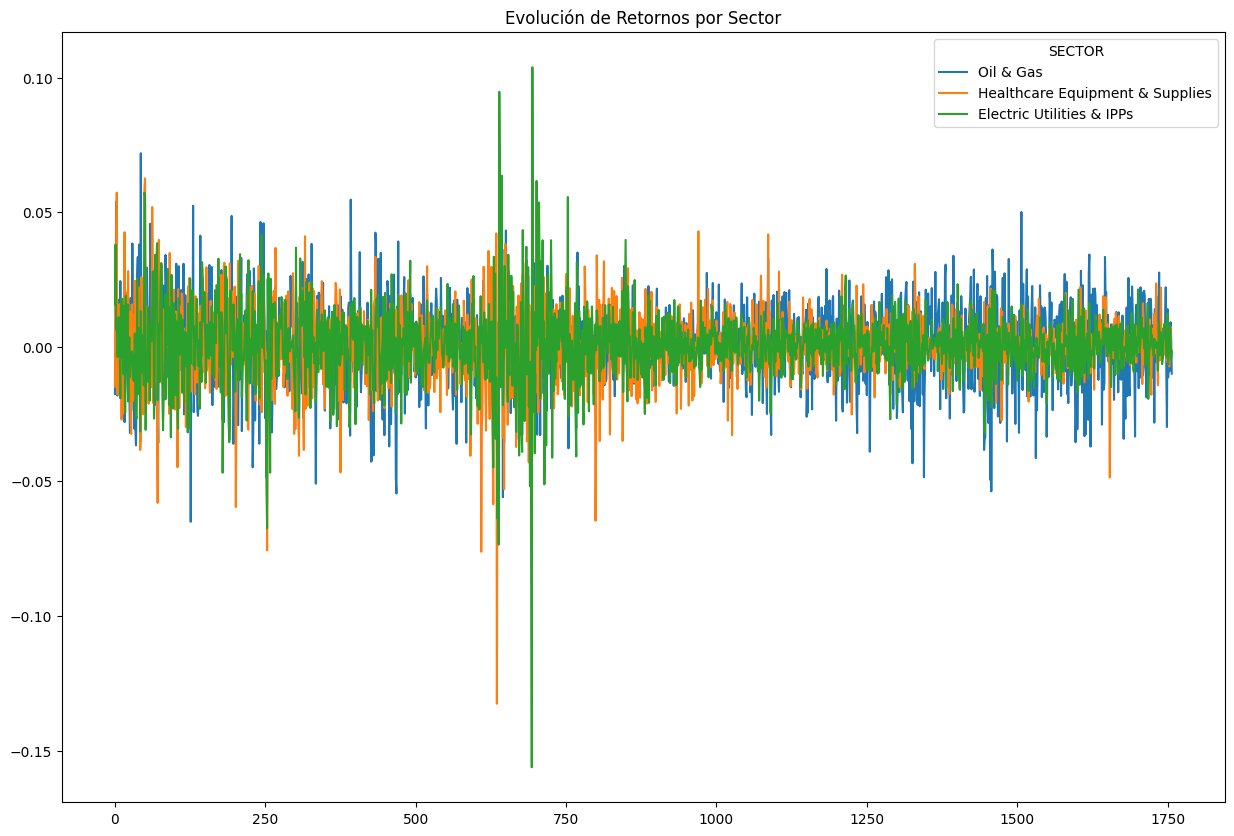

In [223]:
(sectores.loc[['Oil & Gas', 'Healthcare Equipment & Supplies', 'Electric Utilities & IPPs']]).iloc[:, :].T.plot(figsize=(15, 10), title="Evolución de Retornos por Sector")

In [203]:
returns_risk = returns.std(axis=0).sort_values(ascending=True)
returns_risk
# 47, 56, 41, 51

47    0.011005
56    0.011530
41    0.012057
51    0.012201
50    0.013682
54    0.014305
29    0.014425
44    0.014434
17    0.014560
58    0.014678
18    0.015035
60    0.015199
31    0.015391
36    0.015514
53    0.016372
14    0.016540
16    0.016781
46    0.017046
7     0.017120
21    0.017446
35    0.017657
43    0.017736
1     0.017948
4     0.018076
34    0.018315
2     0.018454
45    0.018473
59    0.018536
25    0.018654
57    0.018712
3     0.019082
24    0.019226
55    0.019257
32    0.019334
11    0.019352
37    0.019478
27    0.019571
52    0.019782
12    0.020038
8     0.020245
6     0.020532
10    0.020919
19    0.020994
40    0.021010
5     0.022244
20    0.022259
38    0.022301
30    0.022461
49    0.022620
33    0.022708
22    0.023587
26    0.023997
15    0.024194
48    0.024210
23    0.024859
39    0.025397
28    0.030434
42    0.033874
9     0.039092
13    0.042555
dtype: float64

In [204]:
returns_profit = returns.mean(axis=0).sort_values(ascending=True)
returns_profit

23   -0.000620
28   -0.000406
10   -0.000337
42   -0.000309
38   -0.000297
26   -0.000242
59   -0.000177
57   -0.000095
37   -0.000093
25   -0.000078
27   -0.000070
15   -0.000056
32   -0.000047
45   -0.000038
31   -0.000005
2     0.000017
4     0.000038
13    0.000049
52    0.000059
19    0.000089
14    0.000092
20    0.000117
54    0.000123
34    0.000125
30    0.000143
46    0.000186
9     0.000261
29    0.000273
35    0.000277
8     0.000323
11    0.000334
21    0.000347
1     0.000354
44    0.000362
36    0.000370
39    0.000384
3     0.000387
40    0.000434
58    0.000449
17    0.000453
33    0.000469
60    0.000472
55    0.000475
53    0.000498
6     0.000515
49    0.000522
24    0.000537
7     0.000609
18    0.000616
12    0.000625
50    0.000746
16    0.000759
47    0.000822
41    0.000833
5     0.000880
56    0.000961
48    0.000995
43    0.000996
51    0.001085
22    0.001203
dtype: float64

In [205]:
df_stats = pd.concat([returns_profit, returns_risk], axis=1)
df_stats.columns = ['Media', 'Desviacion']
df_stats.sort_values(['Media', 'Desviacion'], ascending=[False, True])

,Media,Desviacion
22,0.001203,0.023587
51,0.001085,0.012201
43,0.000996,0.017736
48,0.000995,0.024210
56,0.000961,0.011530
5,0.000880,0.022244
41,0.000833,0.012057
47,0.000822,0.011005
16,0.000759,0.016781
50,0.000746,0.013682


In [226]:
sectores.loc[['Healthcare Equipment & Supplies', 'Personal & Household Products & Services', 'Consumer Goods Conglomerates']]


,0,1,2,3,4,5,6,7,8,9,...,1748,1749,1750,1751,1752,1753,1754,1755,1756,1757
SECTOR,,,,,,,,,,,,,,,,,,,,,
Healthcare Equipment & Supplies,-0.014791,0.033971,0.030663,0.057261,-0.017719,-0.003275,-0.009390,0.015822,-0.000109,-0.007825,...,0.007720,-0.005547,0.004089,-0.003439,-0.001983,-0.007316,0.005785,0.007466,-0.002156,-0.001286
Personal & Household Products & Services,-0.022940,-0.026910,0.021447,0.067543,0.011021,0.010206,0.000215,-0.005234,-0.003087,-0.002741,...,0.003139,-0.000683,0.001022,0.001235,-0.006964,-0.002730,0.006211,0.002096,0.005590,-0.005220
Consumer Goods Conglomerates,-0.040546,0.028554,0.077358,0.019657,-0.004879,-0.017263,0.002484,0.000000,-0.014370,-0.022273,...,-0.005857,0.000511,-0.003068,0.009176,-0.000254,-0.005854,-0.004092,0.005623,-0.003958,-0.002947


In [207]:
import cvxpy as cp

# 2% se refiere a anual
fixed_income_return = 0.02 / 252

# Los assets con correlacion inferior al 80% y curtosis <= 5
n_assets = len(returns.iloc[0])

# Retornos esperados
returns_means = returns.mean(axis=0).values

# Matriz de covarianza
returns_cov = returns.cov().values

# CVXPY

w = cp.Variable(n_assets)
risk = cp.quad_form(w, returns_cov)
profit = returns_means @ w


constraints = [
    w >= 0, # solo largos
    w <= 0.35,
    w[drop_indexes] == 0,
    cp.sum(w) == 1, # todo el dinero invertido
]

problem = cp.Problem(cp.Maximize(profit), constraints)
problem.solve(solver=cp.SCS)

weights = w.value
daily_return = returns_means @ weights
daily_volatility = np.sqrt(weights @ returns_cov @ weights.T)
sharpe = (daily_return) / daily_volatility

plot_sharpe(returns, pd.DataFrame([[daily_return, daily_volatility, sharpe]], columns=['return', 'volatility', 'sharpe']))
round_weights(weights)



ValueError: Unable to coerce to DataFrame, shape must be (1, 3): given (10000, 60)

In [ ]:

columns = ["return", "volatility", "sharpe"] + [f"asset{i}" for i in range(n_assets - 1)] + ["Renta Fija"]
simulations = pd.DataFrame(columns=columns, dtype=float)

imax = np.argmax(returns_means)
for vol in np.linspace(daily_volatility, np.sqrt(returns_cov[imax, imax]), num=500):

    simulated_weights = cp.Variable(n_assets)
    riesgo = cp.quad_form(simulated_weights, returns_cov)
    constraints = [

        simulated_weights >= 0, # solo largos
        simulated_weights[-1] == 0.1, # renta fija max 10%
        simulated_weights[:-1] <= 0.2,# Max un 20% en los activos
        cp.sum(simulated_weights) == 1, # todo el dinero invertido
        simulated_weights[drop_indexes] == 0, # No invertimos en los que hemos descartado antes
        riesgo <= vol**2, ## Limitamos el riesgo ##
    ]

    simulated_return = cp.Maximize(returns_means.T @ simulated_weights)
    prob = cp.Problem(simulated_return, constraints)
    resultado = prob.solve()

    used_vol = np.sqrt(riesgo.value)
    obtained_return = simulated_return.value
    obtained_sharpe_ratio = (obtained_return - fixed_income_return) / used_vol

    simulations.loc[len(simulations)] = np.concatenate([[obtained_return], [used_vol], [obtained_sharpe_ratio], simulated_weights.value])

simulations = simulations.sort_values(by='sharpe', ascending=False)
plot_sharpe(returns, mask, simulations)
simulations

In [ ]:
rounded_weights = round_weights(simulations.iloc[0][3:].tolist())
pesos_limpios = [f"{p:g}" for p in rounded_weights]
print(pesos_limpios)
print(f"Peso en {len(rounded_weights[rounded_weights > 0])} activos")